In [1]:
import os
import numpy as np
from scipy.interpolate import interp1d
import statsmodels.api as sm
from tcxreader.tcxreader import TCXReader, TCXTrackPoint
import matplotlib.pyplot as plt
import matplotlib.patches as patches

plt.style.use(['science', 'notebook', 'grid', 'ieee'])
plt.rcParams["figure.figsize"] = (14, 4)
plt.rcParams['figure.dpi'] = 300
plt.rcParams['text.usetex'] = True

# Data preparation

In [2]:
tcx_reader = TCXReader()

In [3]:
tracks = []
path = os.path.join(os.getcwd(), 'activities_tcx/')
with open('activities_filenames') as file:
    activities_filenames = list(map(str.strip, file.readlines()))

In [4]:
activities_filenames[-5:]

['activity_9869207082.tcx',
 'activity_9980295076.tcx',
 'test.tcx',
 'ultra_26.tcx',
 'ultra_40.txc']

In [5]:
for activities_filename in activities_filenames:
    track = tcx_reader.read(path + activities_filename)
    tracks.append(track)

# EDA

In [6]:
len(tracks)

27

In [7]:
for idx, track in enumerate(tracks):
    trackpoints = track.trackpoints
    nan_count = 0
    total_cadence = 0
    for trackpoint in trackpoints:
        if not trackpoint.tpx_ext['RunCadence']:
            nan_count += 1
        else:
            total_cadence += trackpoint.tpx_ext['RunCadence']
    print('Num of trackpoints', len(trackpoints), '; Missing values', nan_count, end=' ; ')
    print('Avg cadence: {:.1f}'.format(2 * total_cadence / (len(trackpoints) - nan_count)))

Num of trackpoints 3173 ; Missing values 5 ; Avg cadence: 158.5
Num of trackpoints 1989 ; Missing values 5 ; Avg cadence: 160.2
Num of trackpoints 1072 ; Missing values 0 ; Avg cadence: 164.1
Num of trackpoints 1083 ; Missing values 3 ; Avg cadence: 165.5
Num of trackpoints 2802 ; Missing values 2 ; Avg cadence: 158.0
Num of trackpoints 2033 ; Missing values 6 ; Avg cadence: 158.3
Num of trackpoints 3033 ; Missing values 0 ; Avg cadence: 164.6
Num of trackpoints 3284 ; Missing values 13 ; Avg cadence: 168.0
Num of trackpoints 3513 ; Missing values 23 ; Avg cadence: 164.7
Num of trackpoints 496 ; Missing values 3 ; Avg cadence: 160.5
Num of trackpoints 606 ; Missing values 3 ; Avg cadence: 162.6
Num of trackpoints 654 ; Missing values 0 ; Avg cadence: 157.0
Num of trackpoints 757 ; Missing values 4 ; Avg cadence: 170.0
Num of trackpoints 1056 ; Missing values 0 ; Avg cadence: 163.5
Num of trackpoints 369 ; Missing values 4 ; Avg cadence: 163.1
Num of trackpoints 584 ; Missing values 3 ;

# Interpolation

In [8]:
all_cadences, all_hrs, all_times = [], [], []
avg_speeds = []
for track in tracks:
    avg_speeds.append(track.avg_speed)
    trackpoints = track.trackpoints
    cadences, hrs, times = [], [], []
    
    for trackpoint in trackpoints:
        if (
            trackpoint.tpx_ext['RunCadence'] and
            trackpoint.hr_value and
            trackpoint.time
           ):

            cadences.append(2 * trackpoint.tpx_ext['RunCadence'])
            hrs.append(trackpoint.hr_value)
            times.append(trackpoint.time)
    
    all_cadences.append(cadences)
    all_hrs.append(hrs)
    all_times.append(times)

In [9]:
signals, times_each_second = [], []
for cadences, hrs, times in zip(all_cadences, all_hrs, all_times):
    start_time = times[0]
    times_seconds = [(time - start_time).seconds for time in times]
    
    cadences_and_hrs = np.array([cadences, hrs])
    interpolate = interp1d(times_seconds, cadences_and_hrs)
    
    new_times_seconds = np.arange(times_seconds[-1] + 1)
    new_cadences_and_hrs = interpolate(new_times_seconds)

    times_each_second.append(new_times_seconds)
    signals.append(new_cadences_and_hrs)

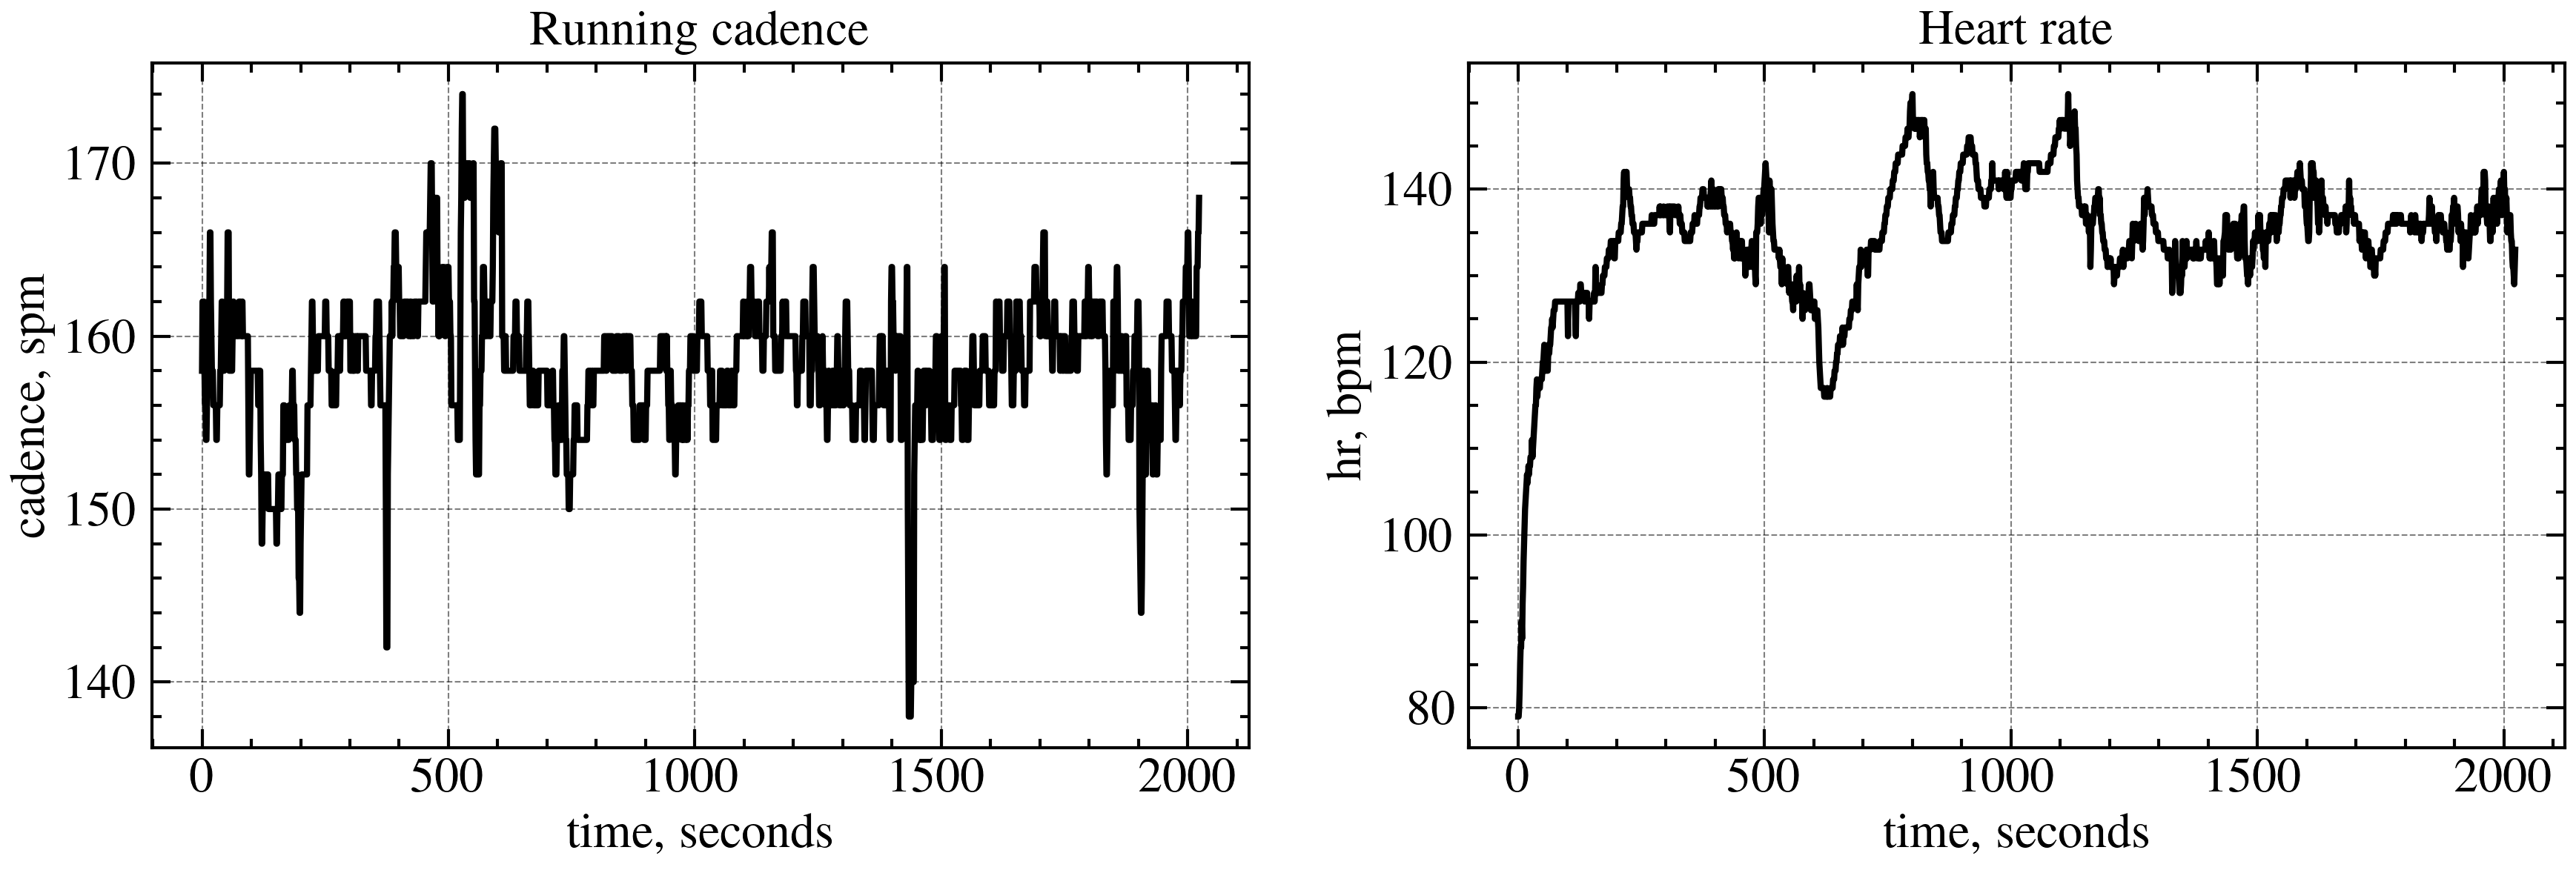

In [10]:
idx = 5
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(times_each_second[idx], signals[idx][0, :])
ax2.plot(times_each_second[idx], signals[idx][1, :])

ax1.set_xlabel('time, seconds')
ax2.set_xlabel('time, seconds')
ax1.set_ylabel('cadence, spm')
ax2.set_ylabel('hr, bpm')
ax1.set_title('Running cadence')
ax2.set_title('Heart rate')

plt.show()

# Cadence -- HR analysis

In [11]:
avg_cadences, avg_hrs = [], []
for signal, times in zip(signals[:-3], times_each_second[:-3]):
    cadences, hrs = signal[0, :], signal[1, :]
    avg_cadences.append(cadences.mean())
    avg_hrs.append(hrs.mean())

avg_cadences = np.array(avg_cadences)
avg_hrs = np.array(avg_hrs) / avg_speeds[:-3]
avg_hrs

array([15.20645261, 14.61253423, 17.26595865, 13.96902819, 16.34005577,
       16.85044331, 14.88165402, 14.84345046, 16.97509826, 24.88936377,
       18.13475443, 17.08698618, 15.53848848, 13.36244352, 20.06212324,
       14.8425311 , 16.53549528, 12.52394919, 13.48585356, 13.3792476 ,
       14.51945009, 14.0666234 , 22.0439886 , 13.91448382])

In [12]:
X = np.column_stack([np.ones(len(avg_cadences)), avg_cadences])
y = avg_hrs
model = sm.OLS(y, X).fit()

intercept, slope = model.params
intercept, slope

(52.299582396445146, -0.22349888646205746)

In [13]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.231
Model:                            OLS   Adj. R-squared:                  0.196
Method:                 Least Squares   F-statistic:                     6.617
Date:                Fri, 23 Dec 2022   Prob (F-statistic):             0.0174
Time:                        23:14:00   Log-Likelihood:                -56.021
No. Observations:                  24   AIC:                             116.0
Df Residuals:                      22   BIC:                             118.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         52.2996     14.100      3.709      0.001      23.059      81.540
x1            -0.2235      0.087     -2.572      0.017      -0.404      -0.043
==============================================================================
Omnibus:                       15.846   Durbin-Watson:                   2.227
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               15.830
Skew:                           1.677   Prob(JB):                     0.000365
Kurtosis:                       5.141   Cond. No.                     4.30e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.3e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [14]:
mu, sigma = model.params[1], np.sqrt(model.cov_params()[1, 1])
rand_sample = np.random.normal(mu, sigma, 100_000)

In [15]:
x = np.linspace(avg_cadences.min() - 6.5, avg_cadences.max() + 2, num=200)
trend = intercept + x * slope

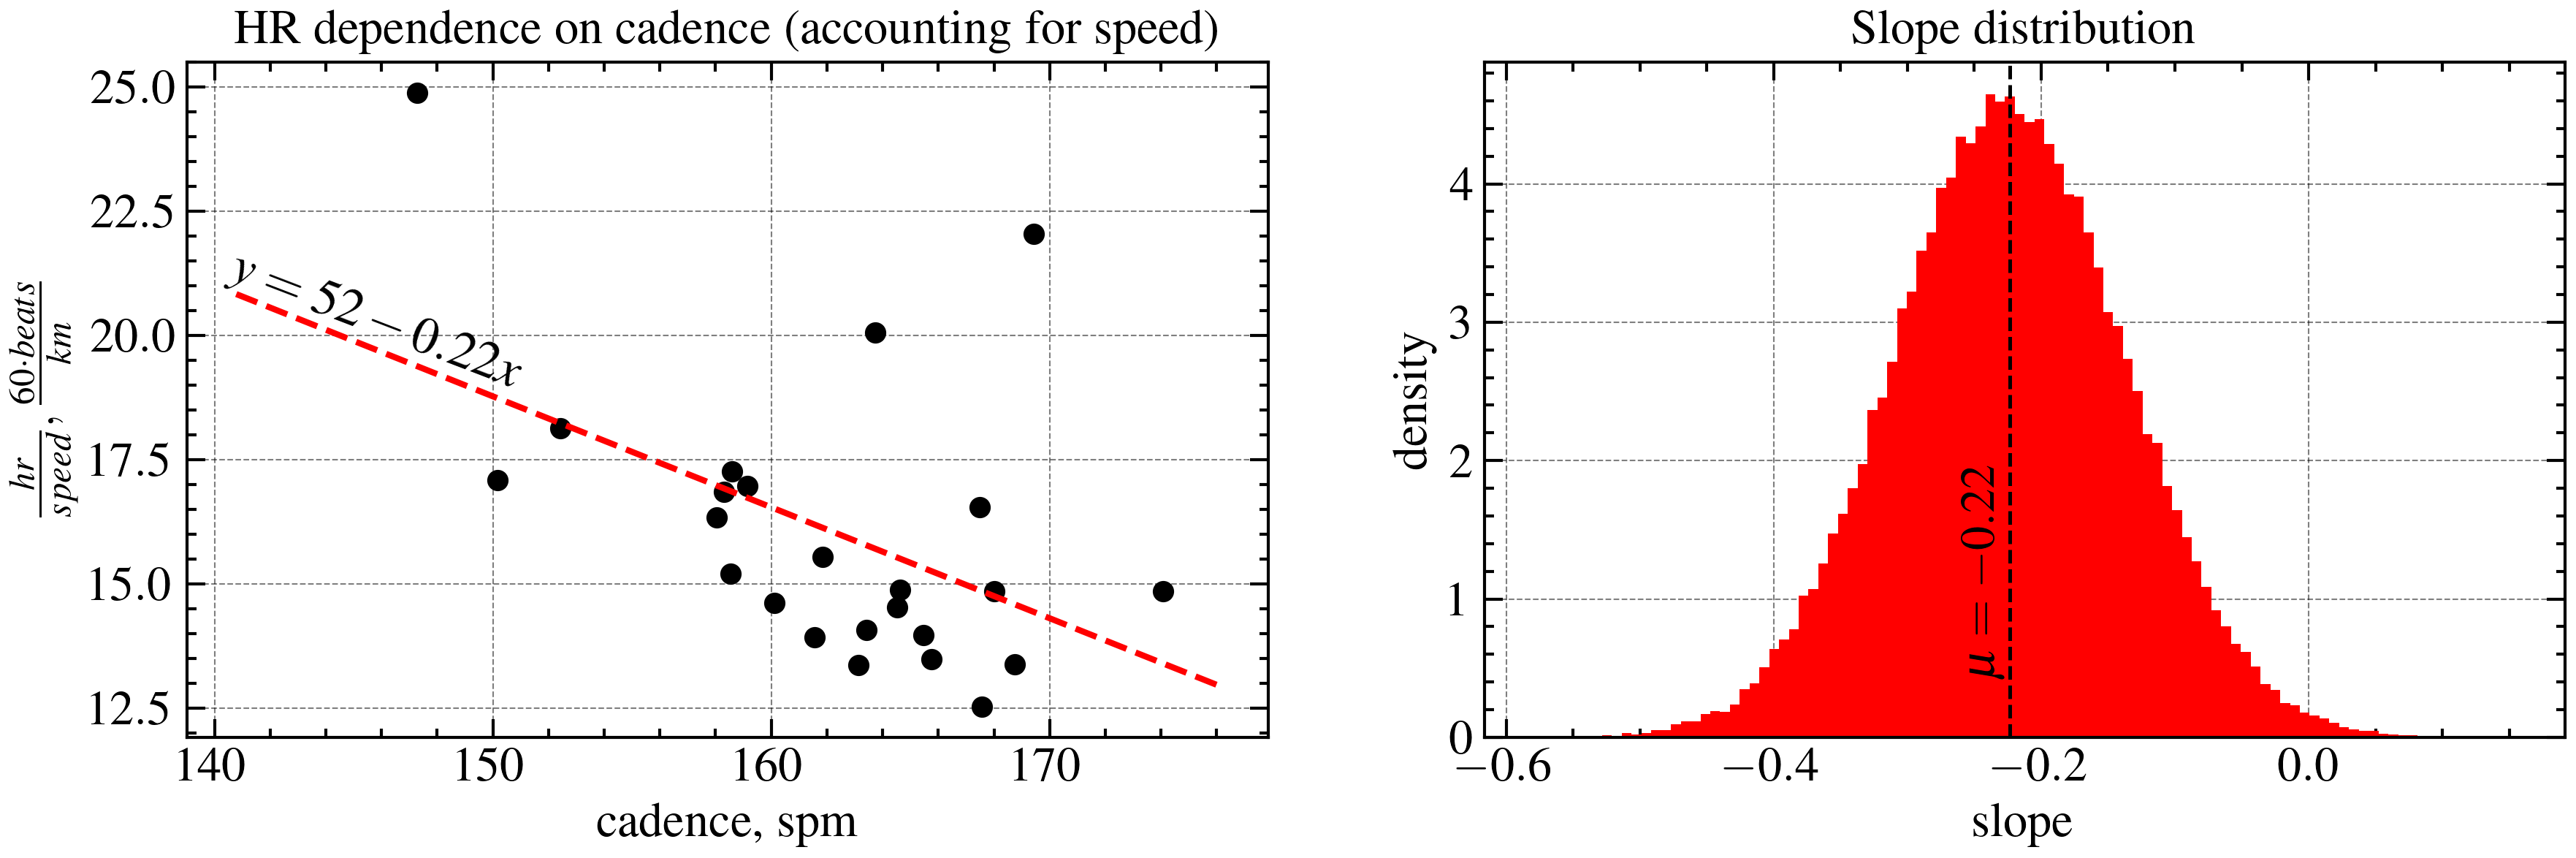

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(avg_cadences, avg_hrs, marker='o', linestyle='none')
ax1.plot(x, trend, c='r')
text_x = avg_cadences.min() - 7
text_y = intercept + text_x * slope - 2
ax1.text(text_x, text_y, r'$y = 52 - 0.22x$', fontsize=17, rotation=-21, color='black')

ax1.set_xlabel('cadence, spm')
ax1.set_ylabel(r'$\frac{hr}{speed}, \frac{60\cdot beats}{km}$')
ax1.set_title('HR dependence on cadence (accounting for speed)')

ax2.hist(rand_sample, bins=100, density=True, color='red')
# ax2.axvline(x=0, c='black', ls='--', lw=1.2)
ax2.axvline(x=slope, c='black', ls='--', lw=1.2)
ax2.text(slope - .037, .5, r'$\mu = -0.22$', color='black', size=16, rotation=90)

ax2.set_xlabel('slope')
ax2.set_ylabel('density')
ax2.set_title('Slope distribution')

plt.show()

# Special case analysis

In [17]:
idx = -3
times_each_second[idx], signals[idx][0, :]
avg_hr_180 = signals[idx][1, 530:724].mean() / 12.9
avg_cadence_180 = signals[idx][0, 530:724].mean()

avg_hr_140 = signals[idx][1, 825:970].mean() / 12.85
avg_cadence_140 = signals[idx][0, 825:970].mean()

avg_hr_160 = signals[idx][1, 1_110:1_176].mean() / 12.95
avg_cadence_160 = signals[idx][0, 1_110:1_176].mean()

avg_hr_180, avg_cadence_180, avg_hr_140, avg_cadence_140, avg_hr_160, avg_cadence_160

(12.834609900440386,
 179.55181768855127,
 13.328860861398095,
 149.29655172413794,
 12.618170118170118,
 163.53030303030303)

#### As one can see from the analysis, the optimal cadence for me is between $160$ and $180$.

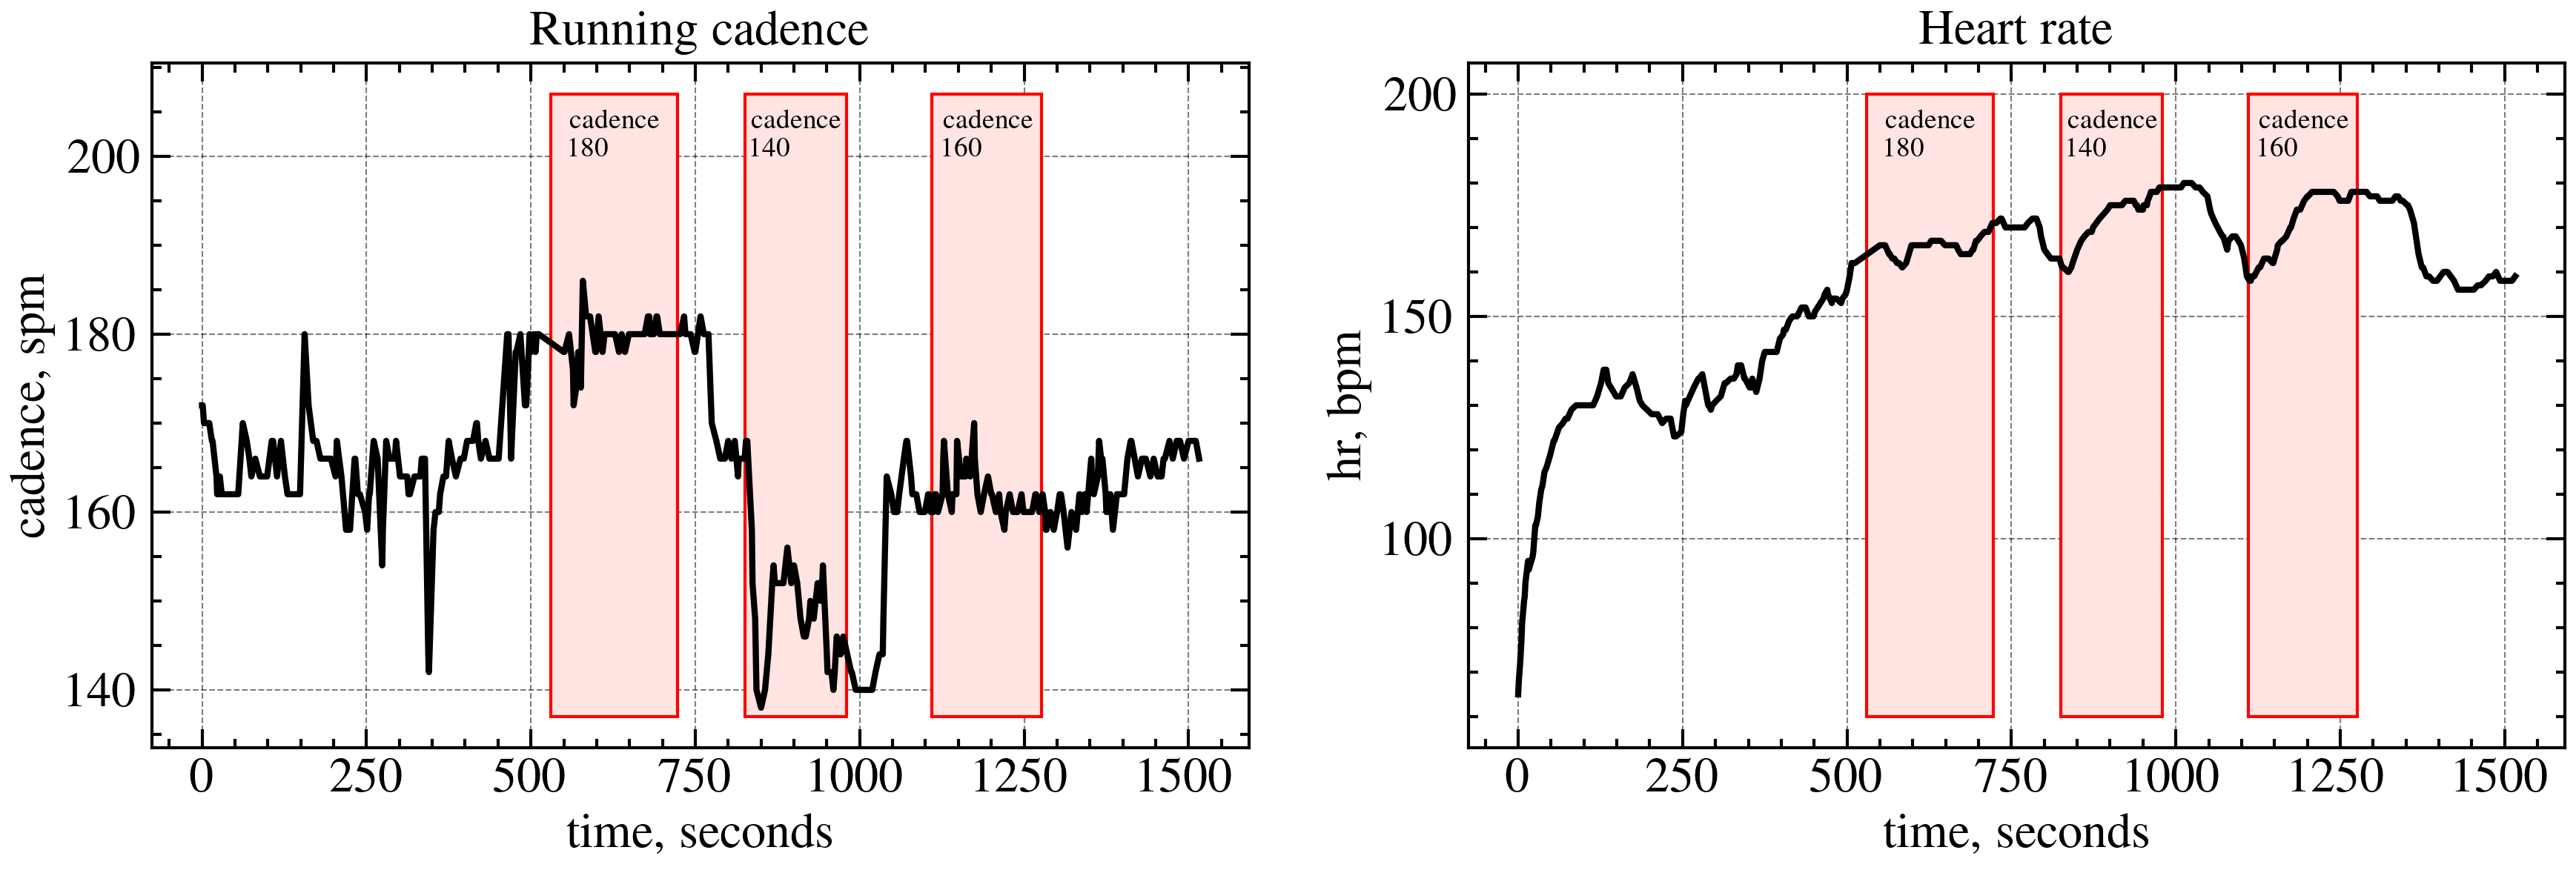

In [18]:
idx = -3
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(times_each_second[idx], signals[idx][0, :])

rect = patches.Rectangle((530, 137), 193, 70, linewidth=1, edgecolor='r', facecolor='mistyrose')
ax1.add_patch(rect)
ax1.text(558, 200, 'cadence\n180', fontsize=9)

rect = patches.Rectangle((825, 137), 155, 70, linewidth=1, edgecolor='r', facecolor='mistyrose')
ax1.add_patch(rect)
ax1.text(835, 200, 'cadence\n140', fontsize=9)

rect = patches.Rectangle((1_110, 137), 166, 70, linewidth=1, edgecolor='r', facecolor='mistyrose')
ax1.add_patch(rect)
ax1.text(1_126, 200, 'cadence\n160', fontsize=9)

ax1.set_xlabel('time, seconds')
ax2.set_xlabel('time, seconds')
ax1.set_ylabel('cadence, spm')
ax2.set_ylabel('hr, bpm')
ax1.set_title('Running cadence')
ax2.set_title('Heart rate')

ax2.plot(times_each_second[idx], signals[idx][1, :])
rect = patches.Rectangle((530, 60), 193, 140, linewidth=1, edgecolor='r', facecolor='mistyrose')
ax2.add_patch(rect)
ax2.text(558, 186, 'cadence\n180', fontsize=9)

rect = patches.Rectangle((825, 60), 155, 140, linewidth=1, edgecolor='r', facecolor='mistyrose')
ax2.add_patch(rect)
ax2.text(835, 186, 'cadence\n140', fontsize=9)

rect = patches.Rectangle((1_110, 60), 166, 140, linewidth=1, edgecolor='r', facecolor='mistyrose')
ax2.add_patch(rect)
ax2.text(1_126, 186, 'cadence\n160', fontsize=9)
plt.show()